In [96]:
import numpy as np
from scipy.io import wavfile
from scipy import signal
from scipy.fftpack import dct
from matplotlib import pyplot as plt
import pyaudio  
import wave  
from io import BytesIO
%matplotlib notebook 

In [90]:
fs, data = wavfile.read('OSR_us_000_0010_8k.wav')
bits = 16
data = data[0:int(3.5*fs)]

<IPython.core.display.Javascript object>


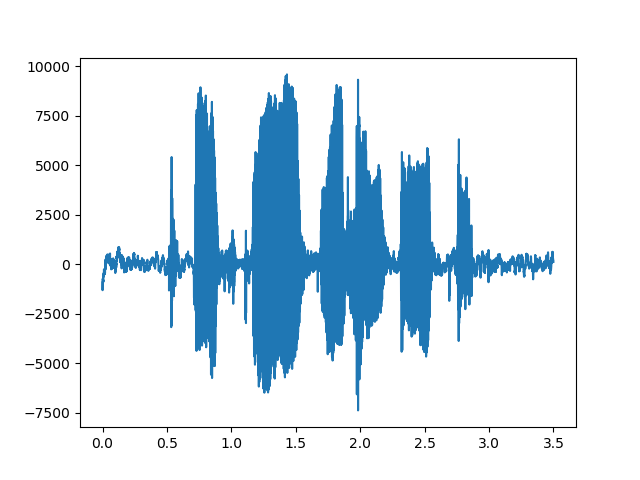

In [91]:
plt.plot(np.arange(data.size)/fs, data)

In [92]:
def play_audio(fs, data):
    data = data.astype(np.int16)
    with BytesIO() as buffer:
        p = pyaudio.PyAudio()
        wavfile.write(buffer, fs, data)
        f = wave.open(buffer,"rb")  
        #define stream chunk   
        chunk = 1024  
        
        stream = p.open(format = p.get_format_from_width(f.getsampwidth()),  
                        channels = f.getnchannels(),  
                        rate = f.getframerate(),  
                        output = True)  
        
        #read data  
        audio_data = f.readframes(chunk)


        #play stream  
        while audio_data:  
            stream.write(audio_data)  
            audio_data = f.readframes(chunk)  

        #stop stream  
        stream.stop_stream()  
        stream.close()  
        p.terminate()

In [93]:
play_audio(fs, data)

In [111]:
#Pre emphasis
pre_emphasis = 0.97
data_pre = np.append(data[0], data[1:]-pre_emphasis*data[:-1])

In [25]:
play_audio(fs, data_pre)

<IPython.core.display.Javascript object>


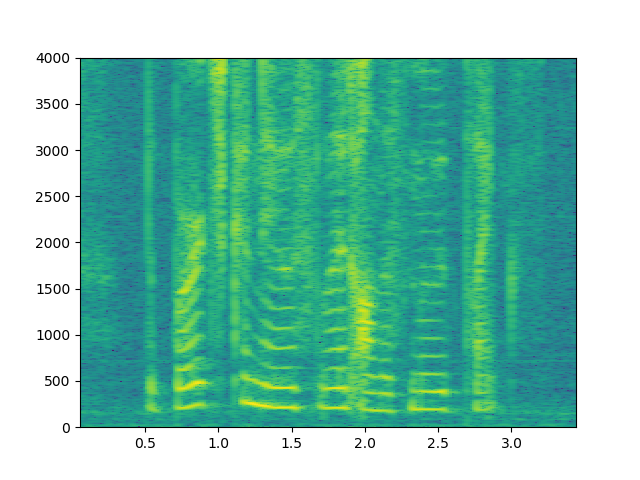

In [112]:
data_norm = data_pre/2**(bits-1)

m = 882
hop_size = m/8
fft_size = 1024

freq, time, Xm = signal.spectrogram(data_norm, fs, window='hanning', nperseg=m, noverlap=m-hop_size, nfft=fft_size)
plt.pcolormesh(time, freq, 20*np.log10(Xm))
plt.show()

In [113]:
#Generate Mel Filter Bank
min_f_hz = 0
max_f_hz = fs/2
n_filters = 40

def to_mel(f): return 2595*np.log10(1+f/700)
def to_hz(f): return (10**(f/2595)-1)*700


min_f_mel = to_mel(0)
max_f_mel = to_mel(max_f_hz)
mel_points = np.linspace(min_f_mel, max_f_mel, n_filters+2)
mel_points_hz = to_hz(mel_points)
fft_bins = np.floor((fft_size+0)*mel_points_hz/fs)

fbank = np.zeros((n_filters, fft_size//2+1))
for m in range(1, n_filters+1):
    f_m_minus = int(fft_bins[m - 1])   # left
    f_m = int(fft_bins[m])             # center
    f_m_plus = int(fft_bins[m + 1])    # right
    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - fft_bins[m - 1]) / (fft_bins[m] - fft_bins[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (fft_bins[m + 1] - k) / (fft_bins[m + 1] - fft_bins[m])
                 

In [ ]:
#My mel filter bank generation
# def to_mel(f):
#     return 1127 * np.log(1+f/700)
# def from_mel(m):
#     return 700 * (np.exp(m/1127) - 1)

# spectrum_bins = 513
# fft_size = 1024
# fs = 44100
# lower_edge_hertz, upper_edge_hertz, num_mel_bins = 0, fs/2, 40
# lower_mel = to_mel(lower_edge_hertz)
# upper_mel = to_mel(upper_edge_hertz)
# freqs = np.linspace(lower_mel, upper_mel, num_mel_bins+2)
# freqs = from_mel(freqs)
# f0 = 1/(fft_size/fs)
# freq_bins = np.rint(freqs/f0).astype(np.int32)
# print(freq_bins)

# output = np.zeros((num_mel_bins, spectrum_bins))

# for i in range(num_mel_bins):
#     f_left   = freq_bins[i]
#     f_center = freq_bins[i+1]
#     f_right  = freq_bins[i+2]
    
#     for point in range(f_left, f_center):
#         output[i, point] = (point-f_left) / (f_center-f_left)
#     for point in range(f_center, f_right+1):
#         output[i, point] = (f_right-point) / (f_right-f_center)

# for i in range(num_mel_bins):
#     #plt.scatter(np.arange(output[i, :].size), output[i, :])
#     plt.plot(output[i,:])
# plt.show()

<IPython.core.display.Javascript object>


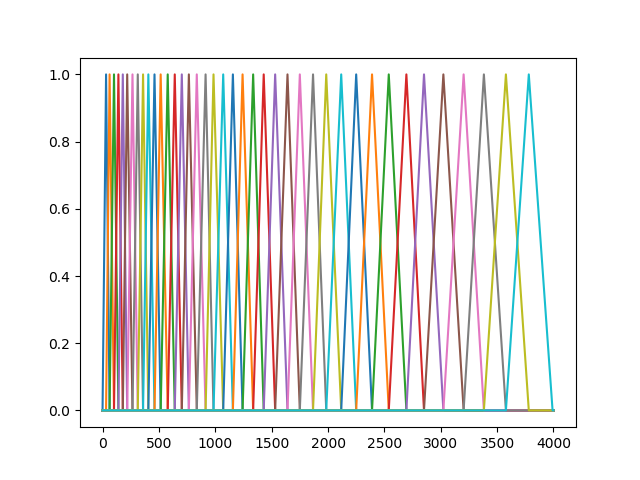

In [114]:
for i in range(fbank.shape[0]):
    plt.plot(freq, fbank[i,:])
plt.show()

<IPython.core.display.Javascript object>


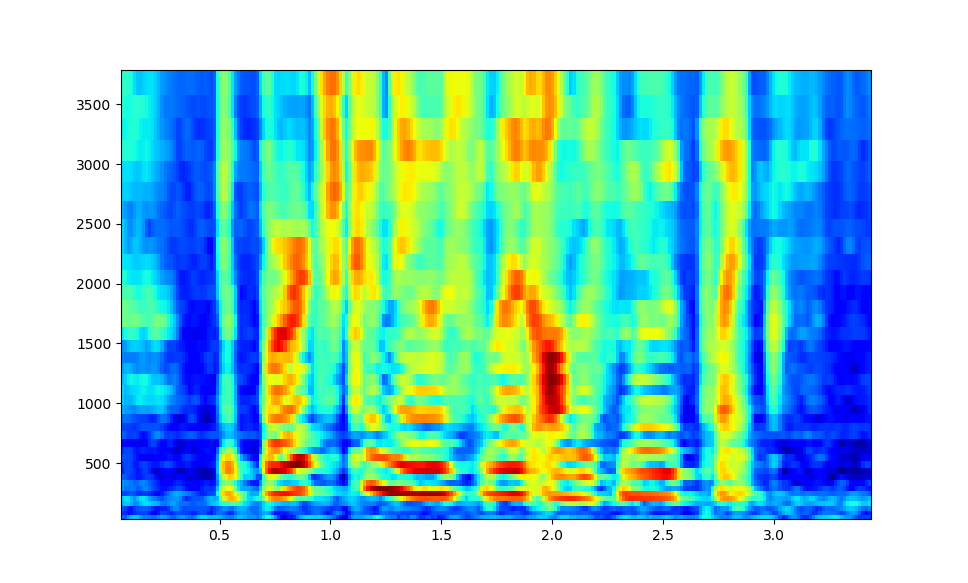

In [115]:
Xm_filtered = fbank @ Xm
Xm_filtered = 20*np.log(Xm_filtered)
plt.pcolormesh(time, mel_points_hz[1:-1], Xm_filtered, cmap='jet')
plt.show()

In [116]:
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct

frame_size = 0.025
frame_stride = 0.01
NFFT = 512
nfilt = 40

sample_rate, signal_ = scipy.io.wavfile.read('OSR_us_000_0010_8k.wav')  # File assumed to be in the same directory
signal_ = signal_[0:int(3.5 * sample_rate)]  # Keep the first 3.5 seconds
emphasized_signal = numpy.append(signal_[0], signal_[1:] - pre_emphasis * signal_[:-1])

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]
frames *= numpy.hamming(frame_length)
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB

<IPython.core.display.Javascript object>


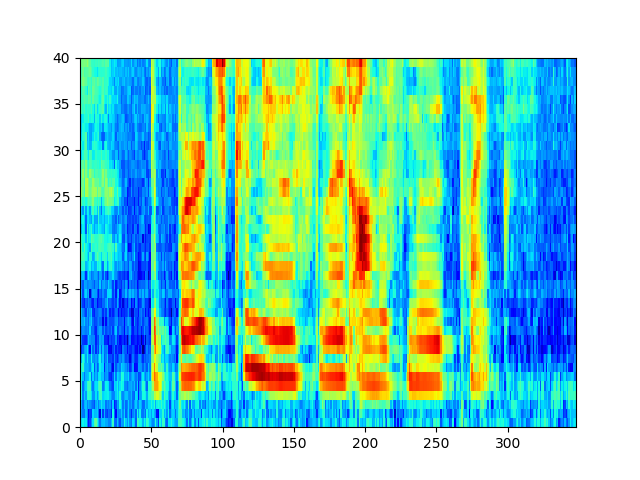

In [117]:
plt.pcolormesh(filter_banks.T, cmap='jet')
plt.show()